# Bulk functional analysis

Bulk RNA-seq yields many molecular readouts that are hard to interpret by themselves. One way of summarizing this information is by inferring pathway and transcription factor activities from prior knowledge.

In this notebook we showcase how to use `decoupler` for transcription factor (TF) and pathway activity inference from a human data-set. The data consists of 6 samples of hepatic stellate cells (HSC) where three of them were activated by the cytokine Transforming growth factor (TGF-β), it is available at GEO [here](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE151251).

<div class="alert alert-info">

**Note**
    
This tutorial assumes that you already know the basics of `decoupler`. Else, check out the [Usage](https://decoupler-py.readthedocs.io/en/latest/notebooks/usage.html) tutorial first.

</div>

## Loading packages

First, we need to load the relevant packages, `scanpy` to handle RNA-seq data
and `decoupler` to use statistical methods.

In [1]:
import scanpy as sc
import decoupler as dc

# Only needed for processing
import numpy as np
import pandas as pd
from anndata import AnnData

## Loading the data

We can download the data easily from GEO:

In [2]:
!wget 'https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE151251&format=file&file=GSE151251%5FHSCs%5FCtrl%2Evs%2EHSCs%5FTGFb%2Ecounts%2Etsv%2Egz' -O counts.txt.gz
!gzip -d -f counts.txt.gz

--2023-03-23 17:46:31--  https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE151251&format=file&file=GSE151251%5FHSCs%5FCtrl%2Evs%2EHSCs%5FTGFb%2Ecounts%2Etsv%2Egz
Resolving www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)... 130.14.29.110, 2607:f220:41e:4290::110
Connecting to www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)|130.14.29.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1578642 (1,5M) [application/octet-stream]
Saving to: ‘counts.txt.gz’

counts.txt.gz       100%[===================>]   1,50M  1,77MB/s    in 0,9s    

2023-03-23 17:46:32 (1,77 MB/s) - ‘counts.txt.gz’ saved [1578642/1578642]



We can then read it using `pandas`:

In [3]:
# Read raw data and process it
adata = pd.read_csv('counts.txt', index_col=2, sep='\t').iloc[:, 5:].T
adata

GeneName,DDX11L1,WASH7P,MIR6859-1,MIR1302-11,MIR1302-9,FAM138A,OR4G4P,OR4G11P,OR4F5,RP11-34P13.7,...,MT-ND4,MT-TH,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP
25_HSCs-Ctrl1,0,9,10,1,0,0,0,0,0,33,...,93192,342,476,493,54466,17184,1302,54099,258,475
26_HSCs-Ctrl2,0,12,14,0,0,0,0,0,0,66,...,114914,355,388,436,64698,21106,1492,62679,253,396
27_HSCs-Ctrl3,0,14,10,0,0,0,0,0,0,52,...,155365,377,438,480,85650,31860,2033,89559,282,448
31_HSCs-TGFb1,0,11,16,0,0,0,0,0,0,54,...,110866,373,441,481,60325,19496,1447,66283,172,341
32_HSCs-TGFb2,0,5,8,0,0,0,0,0,0,44,...,45488,239,331,343,27442,9054,624,27535,96,216
33_HSCs-TGFb3,0,12,5,0,0,0,0,0,0,32,...,70704,344,453,497,45443,13796,1077,43415,192,243


<div class="alert alert-info">

**Note**
    
In case your data does not contain gene symbols but rather gene ids like ENSMBL, you can use the function `sc.queries.biomart_annotations` to retrieve them.
In this other [vignette](https://decoupler-py.readthedocs.io/en/latest/notebooks/pseudobulk.html), ENSMBL ids are transformed into gene symbols.


</div>

<div class="alert alert-info">

**Note**
    
In case your data is not from human but rather a model organism, you can find their human orthologs using `pypath`.
Check this GitHub [issue](https://github.com/saezlab/decoupler-py/issues/5#issuecomment-1137099265) where mouse genes are transformed into human.


</div>

The obtained data consist of raw read counts for six different samples (three controls, three treatments) for ~60k genes.
Before continuing, we will transform our expression data into an `AnnData` object. It handles annotated data matrices
efficiently in memory and on disk and is used in the scverse framework. You can read more about it 
[here](https://scverse.org/) and [here](https://anndata.readthedocs.io/en/latest/).

In [4]:
# Transform to AnnData object
adata = AnnData(adata, dtype=np.float32)
adata.var_names_make_unique()
adata

/home/badi/miniconda3/envs/dcp39/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/badi/miniconda3/envs/dcp39/lib/python3.9/site-packages/anndata/utils.py:111: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


AnnData object with n_obs × n_vars = 6 × 64253

Inside an `AnnData` object, there is the `.obs` attribute where we can store the metadata of our samples.
Here we will infer the metadata by processing the sample ids, but this could also be added from a separate dataframe:

In [5]:
# Process treatment information
adata.obs['condition'] = ['control' if '-Ctrl' in sample_id else 'treatment' for sample_id in adata.obs.index]

# Process sample information
adata.obs['sample_id'] = [sample_id.split('_')[0] for sample_id in adata.obs.index]

# Visualize metadata
adata.obs

,condition,sample_id
25_HSCs-Ctrl1,control,25
26_HSCs-Ctrl2,control,26
27_HSCs-Ctrl3,control,27
31_HSCs-TGFb1,treatment,31
32_HSCs-TGFb2,treatment,32
33_HSCs-TGFb3,treatment,33


## Quality control

Before doing anything we need to ensure that our data passes some quality control thresholds. In transcriptomics it can happen
that some genes were not properly profiled and thus need to be removed.

To filter genes, we will follow the strategy implemented in the function `filterByExpr` from [edgeR](https://rdrr.io/bioc/edgeR/man/filterByExpr.html).
It keeps genes that have a minimum total number of reads across samples (`min_total_count`), and that have a minimum number of counts in a number of samples (`min_count`).

We can plot how many genes do we keep, you can play with the `min_count` and `min_total_count` to check how many genes would be kept when changed:

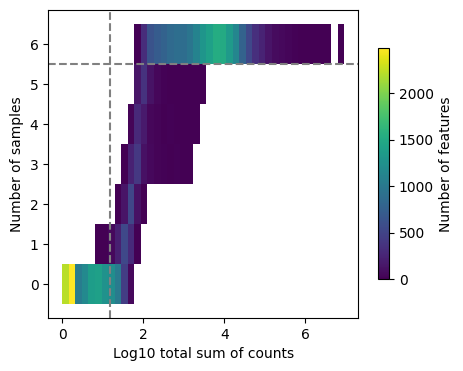

In [6]:
dc.plot_filter_by_expr(adata, group=None, min_count=10, min_total_count=15, large_n=1, min_prop=1)

Here we can observe the frequency of genes with different total sum of counts and number of samples.
For this example, we have decided to keep genes that show some degree of expression in all our samples.

<div class="alert alert-info">

**Note**

This thresholds can vary a lot between datasets, manual assessment of them needs to be considered. For example, it might be
the case that many genes are not expressed in just one sample which they would get removed by the current setting. For this
specific dataset it is fine.

</div>

Once we are content with the threshold parameters, we can perform the actual filtering:

In [7]:
# Obtain genes that pass the thresholds
genes = dc.filter_by_expr(adata, group=None, min_count=10, min_total_count=15, large_n=1, min_prop=1)

# Filter by these genes
adata = adata[:, genes].copy()
adata

AnnData object with n_obs × n_vars = 6 × 17575
    obs: 'condition', 'sample_id'

## Differential expression analysis

In order to identify which are the genes that are changing the most between treatment and control we can perform differential
expression analysis (DEA). For this example, we will perform a simple experimental design where we compare the gene expression
of treated cells against controls. We will use the python implementation of the framework DESeq2, but we could have used any
other one (`limma` or `edgeR` for example). For a better understanding how it works, check
[DESeq2's documentation](https://pydeseq2.readthedocs.io/en/latest/). Note that more complex experimental designs can be used
by adding more factors to the `design_factors` argument.

In [8]:
# Import DESeq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [9]:
# Build DESeq2 object
dds = DeseqDataSet(
    adata=adata,
    design_factors='condition',
    refit_cooks=True,
    n_cpus=8,
)

In [10]:
# Compute LFCs
dds.deseq2()

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 46.24 seconds.

Fitting dispersion trend curve...
... done in 6.19 seconds.

Fitting MAP dispersions...
... done in 59.29 seconds.

Fitting LFCs...
... done in 2.83 seconds.

Refitting 0 outliers.



In [11]:
# Extract contrast between COVID-19 vs normal
stat_res = DeseqStats(dds, contrast=["condition", 'treatment', 'control'], n_cpus=8)

In [12]:
# Compute Wald test
stat_res.summary()

Running Wald tests...
... done in 1.44 seconds.

Log2 fold change & Wald test p-value: condition treatment vs control


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
GeneName,,,,,,
RP11-34P13.7,45.820190,0.066969,0.289150,0.231604,0.816845,0.869800
RP11-34P13.8,29.560568,-0.086227,0.249617,-0.345438,0.729765,0.800351
CICP27,106.257057,0.144798,0.177248,0.816925,0.413971,0.520537
FO538757.2,33.114796,-0.634443,0.286075,-2.217747,0.026572,0.050162
AP006222.2,67.154701,0.577477,0.282791,2.042061,0.041145,0.073917
...,...,...,...,...,...,...
MT-ND6,17962.507812,-0.445816,0.271867,-1.639833,0.101040,0.161684
MT-TE,1284.633179,-0.343227,0.287943,-1.191996,0.233263,0.327339
MT-CYB,55097.121094,-0.323881,0.273819,-1.182828,0.236877,0.331961


In [13]:
# Shrink LFCs
stat_res.lfc_shrink()

Fitting MAP LFCs...
... done in 6.58 seconds.

Shrunk Log2 fold change & Wald test p-value: condition treatment vs control


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
GeneName,,,,,,
RP11-34P13.7,45.820190,0.051019,0.267370,0.231604,0.816845,0.869800
RP11-34P13.8,29.560568,-0.068926,0.234585,-0.345438,0.729765,0.800351
CICP27,106.257057,0.129344,0.172296,0.816925,0.413971,0.520537
FO538757.2,33.114796,-0.523775,0.280507,-2.217747,0.026572,0.050162
AP006222.2,67.154701,0.473780,0.277521,2.042061,0.041145,0.073917
...,...,...,...,...,...,...
MT-ND6,17962.507812,-0.369522,0.265007,-1.639833,0.101040,0.161684
MT-TE,1284.633179,-0.265272,0.273080,-1.191996,0.233263,0.327339
MT-CYB,55097.121094,-0.008593,0.250626,-1.182828,0.236877,0.331961


In [14]:
# Extract results
results_df = stat_res.results_df
results_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
GeneName,,,,,,
RP11-34P13.7,45.820190,0.051019,0.267370,0.231604,0.816845,0.869800
RP11-34P13.8,29.560568,-0.068926,0.234585,-0.345438,0.729765,0.800351
CICP27,106.257057,0.129344,0.172296,0.816925,0.413971,0.520537
FO538757.2,33.114796,-0.523775,0.280507,-2.217747,0.026572,0.050162
AP006222.2,67.154701,0.473780,0.277521,2.042061,0.041145,0.073917
...,...,...,...,...,...,...
MT-ND6,17962.507812,-0.369522,0.265007,-1.639833,0.101040,0.161684
MT-TE,1284.633179,-0.265272,0.273080,-1.191996,0.233263,0.327339
MT-CYB,55097.121094,-0.008593,0.250626,-1.182828,0.236877,0.331961


We can plot the obtained results in a volcano plot:

/home/badi/miniconda3/envs/dcp39/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


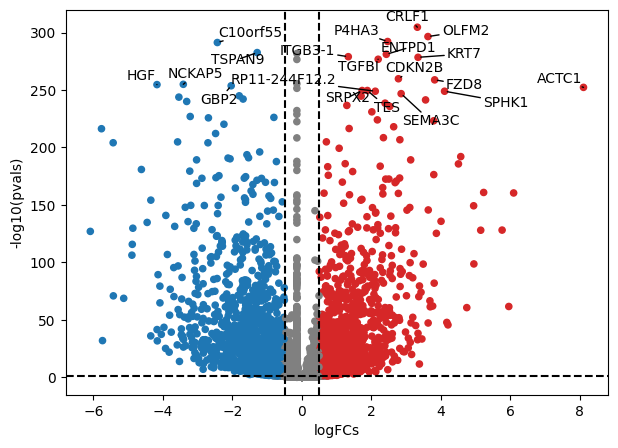

In [15]:
dc.plot_volcano_df(results_df, x='log2FoldChange', y='padj', top=20)

After performing DEA, we can use the obtained gene level statistics to perform enrichment analysis. Any statistic can be used,
but we recommend using the t-values instead of logFCs since t-values incorporate the significance of change in their value.
We will transform the obtained t-values stored in `stats` to a wide matrix so that it can be used by `decoupler`:

In [16]:
mat = results_df[['stat']].T.rename(index={'stat': 'treatment.vs.control'})
mat

GeneName,RP11-34P13.7,RP11-34P13.8,CICP27,FO538757.2,AP006222.2,RP4-669L17.10,MTND1P23,MTND2P28,AC114498.1,MIR6723,...,MT-ND4,MT-TH,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP
treatment.vs.control,0.231604,-0.345438,0.816925,-2.217747,2.042061,-0.384872,-1.373661,-0.53866,-2.343366,-2.503638,...,-1.461126,0.550156,0.704443,0.7292,-1.287858,-1.639833,-1.191996,-1.182828,-1.49019,-2.362806


## Pathway activity inference
To estimate pathway activities we will use the resource PROGENy and the `consensus` method.

For another example on pathway activities please visit this other notebook: [Pathway activity inference](https://decoupler-py.readthedocs.io/en/latest/notebooks/progeny.html).

In [17]:
# Retrieve PROGENy model weights
progeny = dc.get_progeny(top=300)

# Infer pathway activities with consensus
pathway_acts, pathway_pvals = dc.run_consensus(mat=mat, net=progeny)
pathway_acts

,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,WNT,p53
treatment.vs.control,0.163138,0.098991,0.160341,0.522415,-1.638397,0.407927,-0.659291,0.469621,2.594875,-1.197617,-0.188869,0.147423,-0.049042,-0.736517


Let us plot the obtained scores:

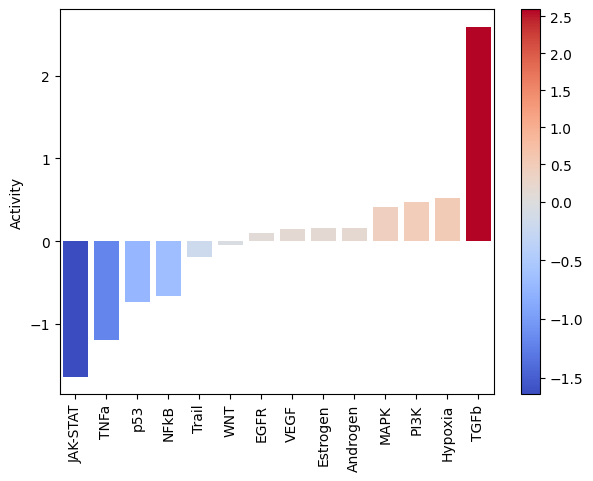

In [18]:
dc.plot_barplot(pathway_acts, 'treatment.vs.control', top=25, vertical=False)

As expected, after treating cells with the cytokine TGFb we see an increase of activity for this pathway.

On the other hand, it seems that this treatment has decreased the activity of other pathways like JAK-STAT or TNFa.

We can visualize the targets of TFGb in a scatter plot:

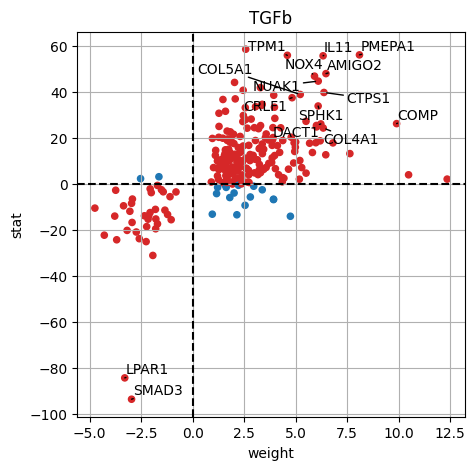

In [19]:
dc.plot_targets(results_df, stat='stat', source_name='TGFb', net=progeny, top=15)

The observed activation of TGFb is due to the fact that majority of its target genes with positive weights have positive
t-values (1st quadrant), and the majority of the ones with negative weights have negative t-values (3d quadrant).

## Transcription factor activity inference
Similarly to pathways, we can estimate transcription factor activities using the resource DoRothEA and the `consensus` method.

For another example on transcription factor activities please visit this other notebook: [Transcription factor activity inference](https://decoupler-py.readthedocs.io/en/latest/notebooks/dorothea.html).

In [20]:
# Retrieve DoRothEA gene regulatory network
dorothea = dc.get_dorothea()

# Infer pathway activities with consensus
tf_acts, tf_pvals = dc.run_consensus(mat=mat, net=dorothea)
tf_acts

,AHR,AR,ARID2,ARID3A,ARNT,ARNTL,ASCL1,ATF1,ATF2,ATF3,...,ZNF217,ZNF24,ZNF263,ZNF274,ZNF384,ZNF584,ZNF592,ZNF639,ZNF644,ZNF740
treatment.vs.control,-0.664002,-0.432842,0.621502,0.039873,0.030808,0.25076,-0.189829,0.55418,0.752058,-0.158055,...,-0.293673,-0.136728,-1.186215,-0.672254,0.645648,-0.257514,-0.415236,0.759006,0.701542,0.350262


Let us plot the obtained scores for the top active/inactive transcription factors:

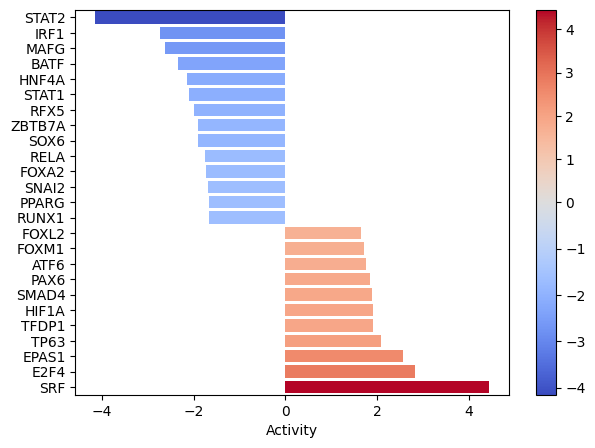

In [21]:
dc.plot_barplot(tf_acts, 'treatment.vs.control', top=25, vertical=True)

SRF, E2F4 and EPAS1 seem to be the most activated in this treatment while STAT2, IRF1 AND MAFG seem to be inactivated.

As before, we can manually inspect the downstream targets of each transcription factor:

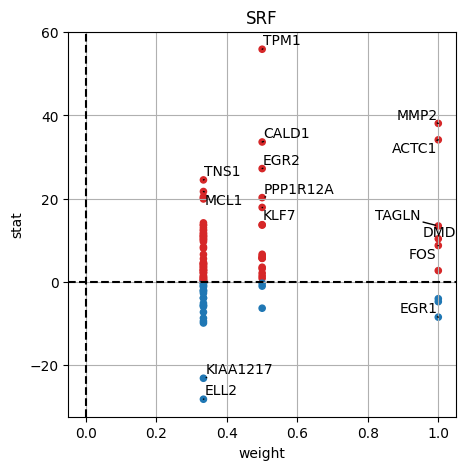

In [22]:
dc.plot_targets(results_df, stat='stat', source_name='SRF', net=dorothea, top=15)

SRF seems to be active in treated cells since their positive targets are up-regulated.

If needed, we can also look at this at the volcano plot:

/home/badi/miniconda3/envs/dcp39/lib/python3.9/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


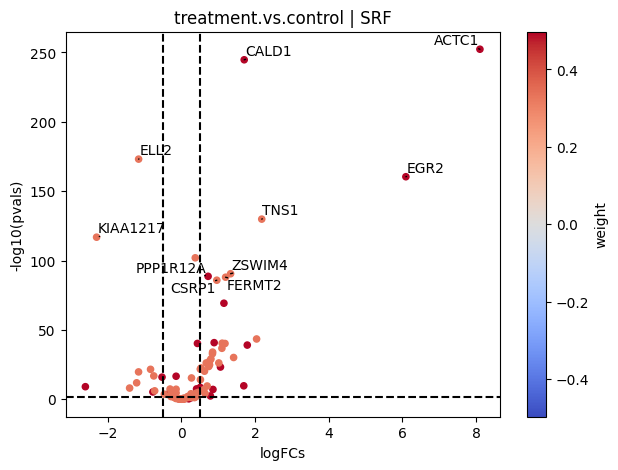

In [23]:
# Extract logFCs and pvals
logFCs = results_df[['log2FoldChange']].T.rename(index={'log2FoldChange': 'treatment.vs.control'})
pvals = results_df[['padj']].T.rename(index={'padj': 'treatment.vs.control'})

# Plot
dc.plot_volcano(logFCs, pvals, 'treatment.vs.control', name='SRF', net=dorothea, top=10, sign_thr=0.05, lFCs_thr=0.5)

## Functional enrichment of biological terms
We can also assign the obtained DEG to biological terms using the resource MSigDB. For this example we will use the `ora`
method, but we could have kept using the `consensus`.

For another example on functional enrichment of biological terms please visit this other notebook: [Functional enrichment of biological terms](https://decoupler-py.readthedocs.io/en/latest/notebooks/msigdb.html).

In [24]:
# Retrieve MSigDB resource
msigdb = dc.get_resource('MSigDB')

# Filter by a desired geneset collection, for example hallmarks
msigdb = msigdb[msigdb['collection']=='hallmark']
msigdb = msigdb.drop_duplicates(['geneset', 'genesymbol'])

# Infer enrichment with ora using significant deg
top_genes = results_df[results_df['padj'] < 0.05].reset_index()
top_genes['group'] = 'treatment.vs.control'
enr_pvals = dc.get_ora_df(top_genes, msigdb, groupby='group', features='GeneName', source='geneset', target='genesymbol')
enr_pvals

,HALLMARK_ADIPOGENESIS,HALLMARK_ALLOGRAFT_REJECTION,HALLMARK_ANDROGEN_RESPONSE,HALLMARK_ANGIOGENESIS,HALLMARK_APICAL_JUNCTION,HALLMARK_APICAL_SURFACE,HALLMARK_APOPTOSIS,HALLMARK_BILE_ACID_METABOLISM,HALLMARK_CHOLESTEROL_HOMEOSTASIS,HALLMARK_COAGULATION,...,HALLMARK_PROTEIN_SECRETION,HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY,HALLMARK_SPERMATOGENESIS,HALLMARK_TGF_BETA_SIGNALING,HALLMARK_TNFA_SIGNALING_VIA_NFKB,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,HALLMARK_UV_RESPONSE_DN,HALLMARK_UV_RESPONSE_UP,HALLMARK_WNT_BETA_CATENIN_SIGNALING,HALLMARK_XENOBIOTIC_METABOLISM
treatment.vs.control,4.159754e-41,4.831792e-24,2.264705e-21,4.825520e-07,2.019933e-37,2.243104e-07,4.416100e-36,4.913311e-18,4.896205e-20,2.239402e-24,...,4.883834e-21,1.057603e-12,2.283553e-16,2.280636e-13,0.0,1.037841e-24,9.445775e-37,1.007110e-29,4.879644e-10,2.064132e-35


 We can then transform these p-values to their -log10 (so that the higher the value, the more significant the p-value).
 We will also set 0s to a minimum p-value so that we do not get infinites.

In [25]:
# Set 0s to min p-value
enr_pvals.values[enr_pvals.values == 0] = np.min(enr_pvals.values[enr_pvals.values != 0])

# Log-transform
enr_pvals = -np.log10(enr_pvals)

Then we can visualize the most enriched terms:

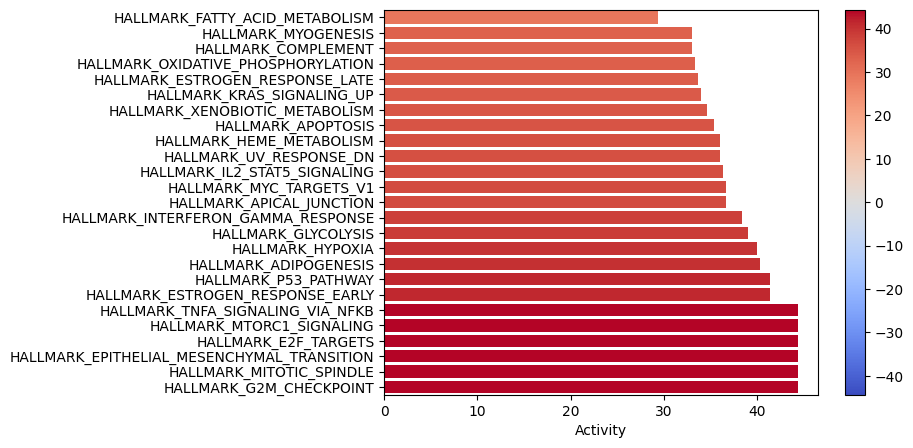

In [26]:
dc.plot_barplot(enr_pvals, 'treatment.vs.control', top=25, vertical=True)

TNFa and interferons response (JAK-STAT) processes seem to be enriched. We previously observed a similar result with the PROGENy pathways, were they were significantly downregulated. Therefore, one of the limitations of using a prior knowledge resource without weights is that it doesn't provide direction.

## Enrichment of ligand-receptor interactions

Recently, study of interactions between ligands and receptors have gained significant traction, notably pushed by the democratization of single cell sequencing technologies. While most methods (such as the one described in LIANA) are developed for single cell datasets, they rely on a relatively simple assumption of co-expression or co-regulation of two (or more in the context of complexes) genes acting as ligand and receptors to propose hypothetical ligand-receptor interaction events. This concept can seamlessly be applied to a bulk RNA dataset, where the assumption is that sender and receiver cells are convoluted in a single dataset, but the observation of significant co-regulation of ligand and receptors should still correspond to hypothetical ligand-receptor interaction events.

At the core, most current ligand-receptor interaction methods rely on averaging the measurements obtained for ligand and receptor and standardizing them against a background distribution.  Thus, an enrichment method based on a weighted mean can emulate this, where the sets are simply the members of a ligand receptor pair (or more in the context of complexes).

Thus, we can extract ligand-receptor interaction ressources from the LIANA package (available both in [R](https://saezlab.github.io/liana/) and [python](https://liana-py.readthedocs.io/en/latest/)), and use it as a prior knowledge network with decoupler to find the most significant pairs of ligand-receptors in a given bulk dataset.

While more work is required to fully understand the functional relevance of the highlighted ligand-receptor interactions with such an approach, this represents a very straightforward and intuitive approach to embed a bulk RNA dataset with ligand-receptor interaction prior knowledge.


First, we extract ligand-receptor interactions from liana, and decomplexify them to format them into an appropriate decoupleR input.

In [27]:
import liana as ln

liana_lr = ln.resource.select_resource()
liana_lr = ln.resource.explode_complexes(liana_lr)

# Create two new DataFrames, each containing one of the pairs of columns to be concatenated
df1 = liana_lr[['interaction', 'ligand']]
df2 = liana_lr[['interaction', 'receptor']]

# Rename the columns in each new DataFrame
df1.columns = ['interaction', 'genes']
df2.columns = ['interaction', 'genes']

# Concatenate the two new DataFrames
liana_lr = pd.concat([df1, df2], axis=0)
liana_lr['weight'] = 1

# Find duplicated rows
duplicates = liana_lr.duplicated()

# Remove duplicated rows
liana_lr = liana_lr[~duplicates]


liana_lr

,interaction,genes,weight
0,LGALS9|PTPRC,LGALS9,1
1,LGALS9|MET,LGALS9,1
2,LGALS9|CD44,LGALS9,1
3,LGALS9|LRP1,LGALS9,1
4,LGALS9|CD47,LGALS9,1
...,...,...,...
5849,BMP2|ACTR2,ACTR2,1
5850,BMP15|ACTR2,ACTR2,1
5851,CSF1|CSF3R,CSF3R,1
5852,IL36G|IFNAR1,IFNAR1,1


Then we can use the weighted mean to find the significant co-regulated pairs of ligand and receptors.

In [28]:
# Infer pathway activities with consensus
lr_mean, lr_norm_mean, lr_corr_mean, lr_pvalue = dc.run_wmean(mat=mat, net=liana_lr, source='interaction', target='genes', min_n=2, times = 100)

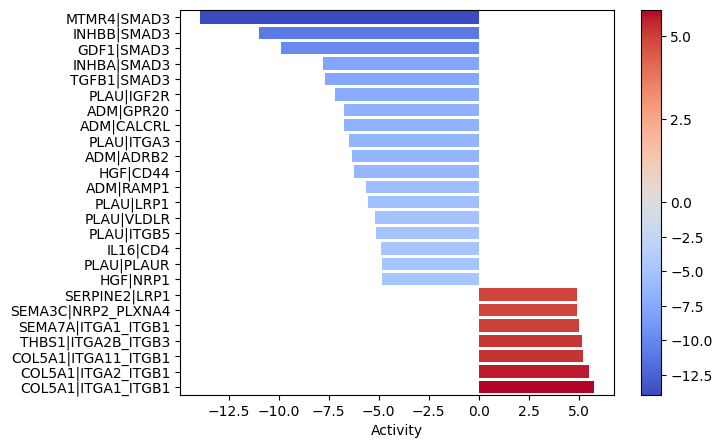

In [29]:
dc.plot_barplot(lr_norm_mean, 'treatment.vs.control', top=25, vertical=True)

Interactions between colagens and the ITG_ITG complexes seems to be quite enrichned. That is especially relevant since the EMT pathway was significantly enriched in the functional pathway analysis.